# Run inference

* **Last Modified**: 17-03-2022
* **Authors**: Sam Budd, Gonzalo Mateo-García
---

> Run inference on Sentinel-2 images using a trained model

This notebook shows how to load a trained model from a experiment config file. With that model we will then make predictions on new Sentinel-2 images.

**Note**: If you run this notebook in Google Colab change the running environment to use a GPU.

In [1]:
# Install the ml4floods package
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

In [2]:
import os

## Step 0: Download the necessary data

In order to run this tutorial you need to download the necesary data (pretrained models and GeoTIFF files to run inference). For this tutorial we will get it from our [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH). For other alternatives see [the download *WorldFloods* documentation](./worldfloods_dataset.md).

### Step 0a: mount the Public folder if you are in Google Colab
If you're running this tutorial in Google Colab you need to add a *‘add a shortcut to your Google Drive’* from the [public Google Drive folder](https://drive.google.com/folderview?id=1dqFYWetX614r49kuVE3CbZwVO6qHvRVH) and mount that directory with the following code:

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    assert os.path.exists('/content/drive/My Drive/Public WorldFloods Dataset'), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/u/0/folders/1dqFYWetX614r49kuVE3CbZwVO6qHvRVH"
    google_colab = True
    path_to_dataset_folder = '/content/drive/My Drive/Public WorldFloods Dataset'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    experiment_name = "WFV1_unet"
    folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)
except ImportError as e:
    print(e)
    print("Setting google colab to false, it will need to install the gdown package!")
    google_colab = False

No module named 'google.colab'


### Step 0b: Download the data with the gdown package if you are in a jupyter notebook

Download the data using the `gdown` package (if not installed run: `pip install gdown`).

In [3]:
# Download pre-trained model from Google Drive folder
if not google_colab:
    experiment_name = "WFV1_unet"
    # Download val folder
    path_to_dataset_folder = '.'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    val_folder = os.path.join(dataset_folder, "val")
    
    folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)
    
    if not os.path.exists(folder_name_model_weights):
        import gdown
        gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                              output=folder_name_model_weights)

    if not os.path.exists(val_folder):
        import gdown
        os.makedirs(val_folder, exist_ok=True)
        # https://drive.google.com/drive/folders/1ogcNupGr0q6nLwS7BBQQ8PzILyONah12?usp=sharing
        gdown.download_folder(id="1ogcNupGr0q6nLwS7BBQQ8PzILyONah12", quiet=False, use_cookies=False,
                              output=val_folder)

Retrieving folder list


Processing file 1vk48dyx5dQ9JzDmx9m8z-ezNqcmA7kJG config.json
Processing file 1mDQUzVL45_GTiILSDNeb-UN8xNROsKyC model.pt
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1vk48dyx5dQ9JzDmx9m8z-ezNqcmA7kJG
To: /home/gonzalo/git/ml4floods/jupyterbook/content/ml4ops/WFV1_unet/config.json
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.20k/1.20k [00:00<00:00, 629kB/s]
Downloading...
From: https://drive.google.com/uc?id=1mDQUzVL45_GTiILSDNeb-UN8xNROsKyC
To: /home/gonzalo/git/ml4floods/jupyterbook/content/ml4ops/WFV1_unet/model.pt
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31.2M/31.2M [00:00<00:00, 46.3MB/s]
Download completed


## Step 1: Get config

In [4]:
from ml4floods.models.config_setup import get_default_config

config_fp = os.path.join(folder_name_model_weights, "config.json")

config = get_default_config(config_fp)

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
config["model_params"]["max_tile_size"] = 128

Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                

## Step 2: Load pre-trained model

In [5]:
from ml4floods.models.model_setup import get_model

model_folder = os.path.dirname(folder_name_model_weights)
if model_folder == "":
    model_folder = "."

config["model_params"]['model_folder'] = model_folder
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
model.to("cuda") # comment this line if your machine does not have GPU

Loaded model weights: ./WFV1_unet/model.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

In [6]:
from ml4floods.models.model_setup import get_model_inference_function

inference_function = get_model_inference_function(model, config,apply_normalization=True)

Getting model inference function


## Step 3: Run Inference

The `inference_function` let us run the model on large tiles. For doing this it follows the tiling and stiching strategy
described in [Huang et al. 2019](https://arxiv.org/abs/1805.12219).

In the next cell we load a GeoTIFF Sentinel-2 from the *WorldFloods* `val` dataset and we run the segmentation model on it. Afterwards we load the ground truth and the JRC permanent water layer GeoTIFF and plot it for comparison purposes.

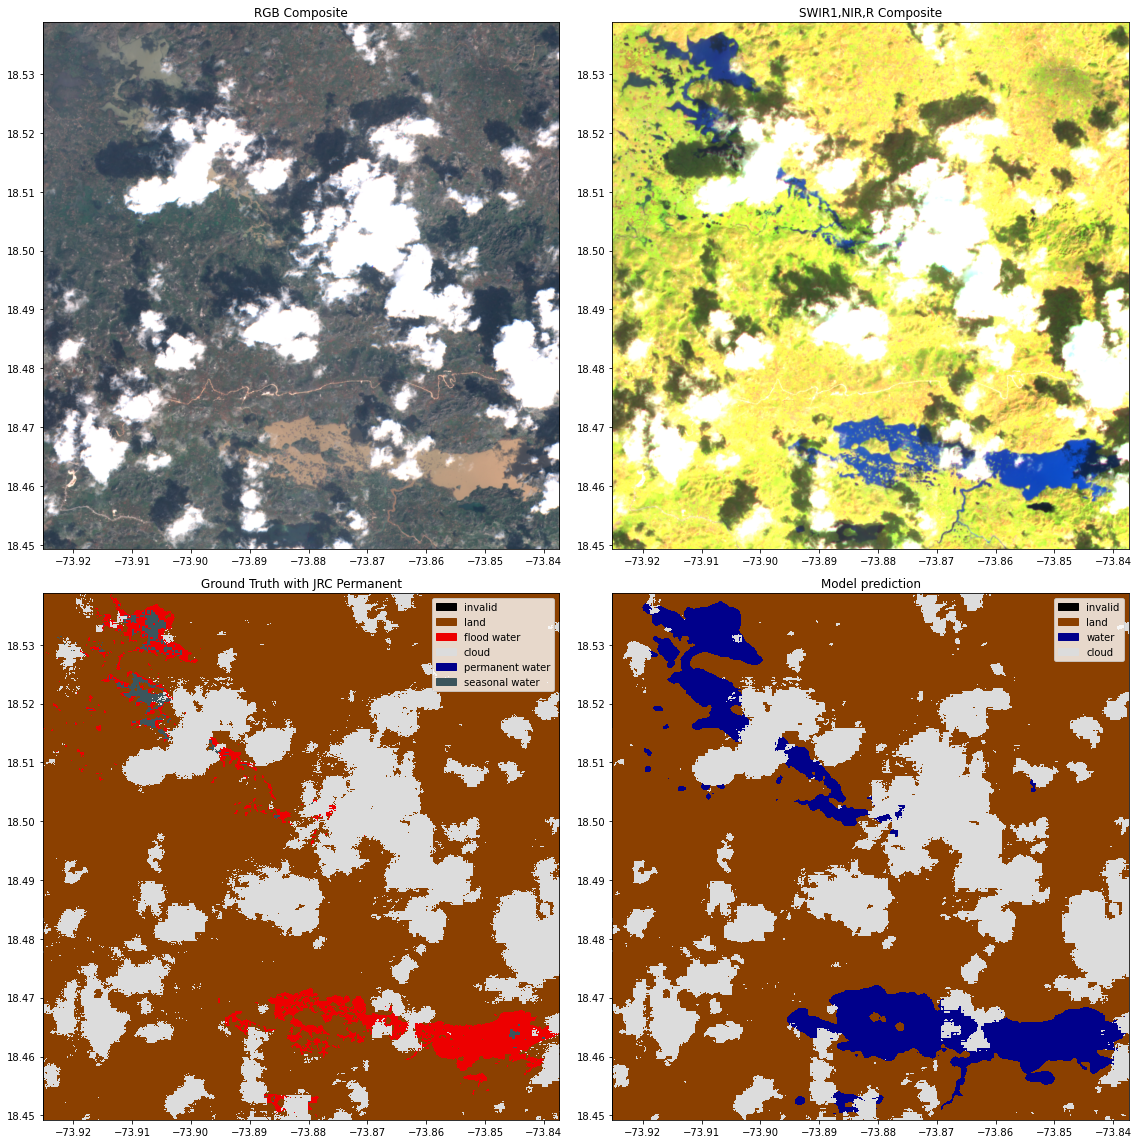

In [8]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration

# dataset_folder = gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/
event_id = "RS2_20161008_Water_Extent_Corail_Pestel.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)

# Make predictions
outputs = inference_function(torch_inputs.unsqueeze(0))[0] # (num_classes, h, w)
prediction = torch.argmax(outputs, dim=0).long() # (h, w)

# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])


# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_s2_rbg_image(torch_inputs, transform=transform, ax=axs[0,0])
axs[0,0].set_title("RGB Composite")
plot_utils.plot_s2_swirnirred_image(torch_inputs, transform=transform, ax=axs[0,1])
axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(torch_targets, torch_permanent_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction")
plt.tight_layout()


## Step 4: Vectorise the water masks and plot them

In the code bellow `data_out` is a `GeoDataFrame` object. You can save it as a shapefile with [`save_file`](https://geopandas.org/docs/user_guide/io.html).

<AxesSubplot:>

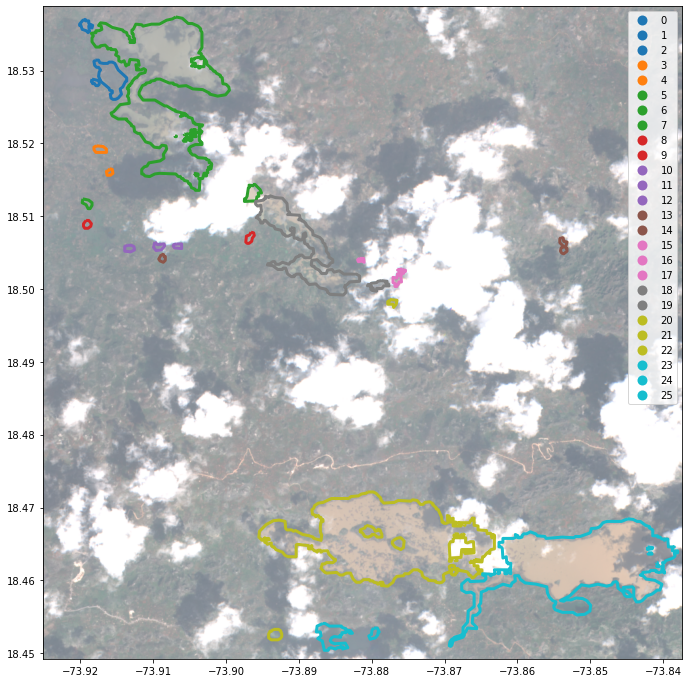

In [9]:
from ml4floods.models import postprocess
from ml4floods.visualization import plot_utils
import geopandas as gpd
import numpy as np

prob_water_mask = outputs[1].cpu().numpy()
binary_water_mask = prob_water_mask>.5

geoms_polygons = postprocess.get_water_polygons(binary_water_mask, transform=transform)

data_out = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
fig, ax = plt.subplots(1,1, figsize=(12, 12))
data_out.plot("id",legend=True,categorical=True,ax=ax,facecolor="None",edgecolor=None,linewidth=3)
plot_utils.plot_s2_rbg_image(torch_inputs, transform=transform, ax=ax, alpha=.6,
                             channel_configuration=channel_configuration)